In [26]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix, precision_recall_curve, auc

First we need to determine the classes that contain the top three most amount of observations. We can do this by going into each folder, counting the number of files in each folder, and taking the folder names of the folders with the most files.

In [27]:
data_folder = pathlib.Path('G:/My Drive/University of Waterloo Files/Applied Machine Learning and Artificial Intelligence/Term 1/CSCN 8010 - Foundations of Machine Learning')
birds = os.listdir(data_folder / "train")

num_classes = np.array([len(os.listdir(data_folder / "train" / bird)) for bird in birds])
num_classes = num_classes.argsort()
indexes_of_top_three_classes = num_classes[::-1][:3]
top_three_classes = [os.listdir(data_folder / "train")[i] for i in indexes_of_top_three_classes]

print("Selected Birds and their Counts:")
print(top_three_classes[0], len(os.listdir(data_folder / "train" / top_three_classes[0])))
print(top_three_classes[1], len(os.listdir(data_folder / "train" / top_three_classes[1])))
print(top_three_classes[2], len(os.listdir(data_folder / "train" / top_three_classes[2])))

Selected Birds and their Counts:
RUFOUS TREPE 263
HOUSE FINCH 248
OVENBIRD 233


Per the assignment instructions, we now delete any folder that is not one of the three classes above.

In [28]:
path = 'G:/My Drive/University of Waterloo Files/Applied Machine Learning and Artificial Intelligence/Term 1/CSCN 8010 - Foundations of Machine Learning'

for species in os.listdir(data_folder / "train"):
    if species not in top_three_classes:
        shutil.rmtree(path + "/train/" + species)

for species in os.listdir(data_folder / "validation"):
    if species not in top_three_classes:
        shutil.rmtree(path + "/validation/" + species)

for species in os.listdir(data_folder / "test"):
    if species not in top_three_classes:
        shutil.rmtree(path + "/test/" + species)

Next we move on to loading the training, validation, and test files, as well as the base model that we want to fine-tune.

In [29]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32,
    shuffle = False)

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))
conv_base.summary()

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
         

To get an idea of what types of birds we are looking at, let's plot some of the birds from the validation set.

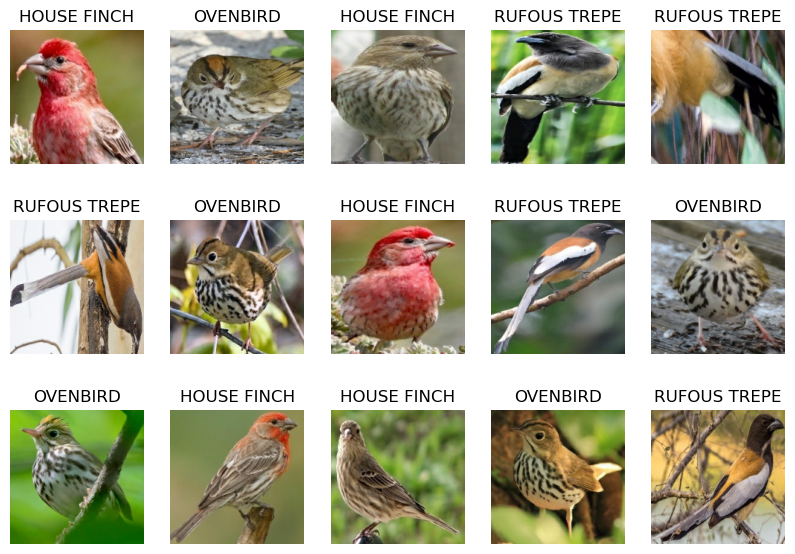

In [30]:
class_labels = validation_dataset.class_names
for images, labels in validation_dataset: 
    plt.figure(figsize=(10, 7))
    for i in range(15):  # Display up to 9 images
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[labels[i]])
        plt.axis("off")

    plt.show()

Before moving on to fine-tuning, we will define our data augmentation object now. We want to apply a horizontal flip, a rotation, and a zoom onto each image. This will allow the model to better interpret different variations of images it might see during testing.

In [31]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Now we move on to fine-tuning. First, we will freeze the base model and train the head of the network. We will add two dense layers with 256 neurons, a dropout later that drops 20% of the neurons, and an output layer that yields the probability of the inputs being in each class.

In [32]:
conv_base.trainable = False

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset)

Epoch 1/10
24/24 [==============================] - 3s 81ms/step - loss: 17.7852 - accuracy: 0.8629 - val_loss: 5.0804 - val_accuracy: 0.9333
Epoch 2/10
24/24 [==============================] - 3s 76ms/step - loss: 0.4382 - accuracy: 0.9758 - val_loss: 5.1008 - val_accuracy: 0.9333
Epoch 3/10
24/24 [==============================] - 2s 74ms/step - loss: 0.0286 - accuracy: 0.9973 - val_loss: 5.8214 - val_accuracy: 0.9333
Epoch 4/10
24/24 [==============================] - 2s 70ms/step - loss: 1.8855 - accuracy: 0.9664 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 2s 74ms/step - loss: 3.1353e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 3s 75ms/step - loss: 0.0768 - accuracy: 0.9960 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 3s 76ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accur

We can visualise the results below.

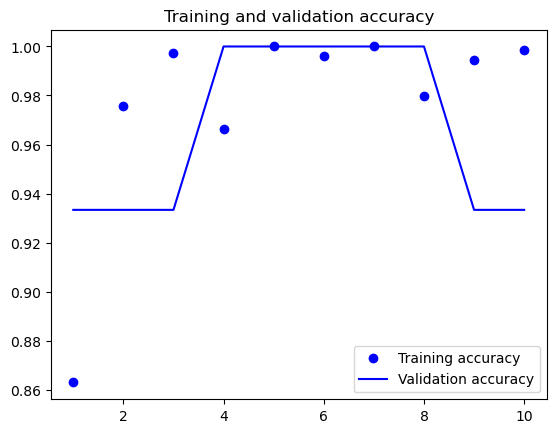

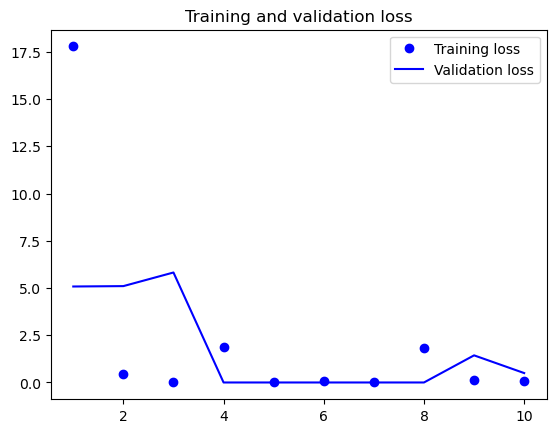

In [33]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Now that the head is trained, we can unfreeze the last few layers of the base model and continue to fine-tune the model.

In [34]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset)

Epoch 1/10


24/24 [==============================] - 3s 87ms/step - loss: 0.0290 - accuracy: 0.9973 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 3s 89ms/step - loss: 5.9831e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 3s 82ms/step - loss: 5.8161e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 3s 87ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 3s 80ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 3s 82ms/step - loss: 1.9227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 3s 84ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000

Once again, we can visualize the results of the fine-tuning process below.

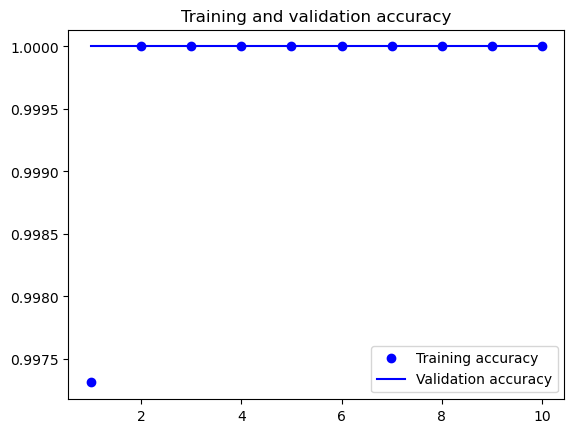

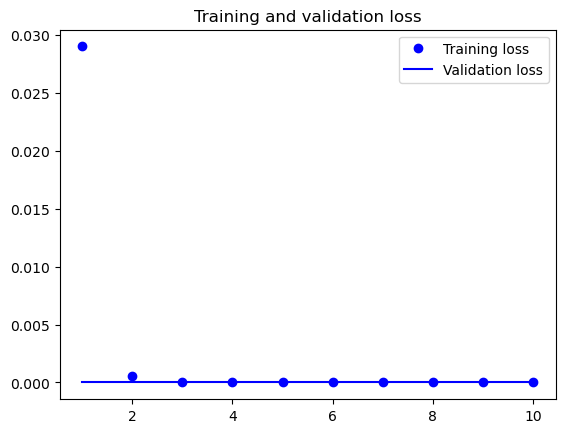

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We will now move on to applying the model to our test set and evaluating the results.

In [36]:
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.concatenate([labels for features, labels in test_dataset], axis = 0)

conf_mat = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

accuracy_metrics = classification_report(y_true, y_pred, target_names = test_dataset.class_names)
print("\nAccuracy Metrics:")
print(accuracy_metrics)

1/1 [==============================] - 0s 116ms/step

Confusion Matrix:
[[5 0 0]
 [0 5 0]
 [0 0 5]]

Accuracy Metrics:
              precision    recall  f1-score   support

 HOUSE FINCH       1.00      1.00      1.00         5
    OVENBIRD       1.00      1.00      1.00         5
RUFOUS TREPE       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Plotting the precision-recall curves:

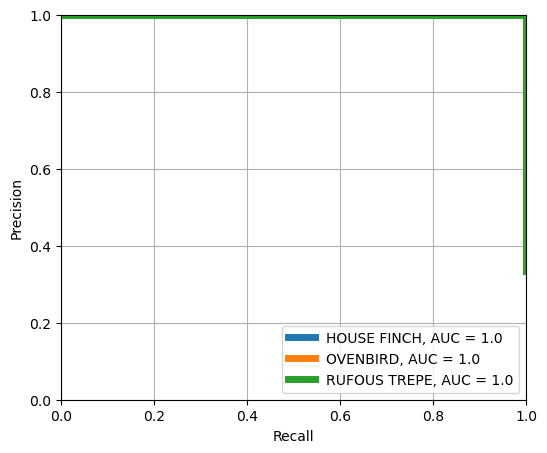

In [37]:
plt.figure(figsize=(6, 5))
classes = test_dataset.class_names

for i in range(len(classes)):

    precisions, recalls, thresholds = precision_recall_curve(
        y_true == i, y_pred_prob[:, i])

    plt.plot(recalls, precisions, linewidth = 5,
             label = classes[i] + ", AUC = " + str(round(auc(recalls, precisions), 2)))
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid()
    plt.legend(loc="lower right")
    
plt.show()

Since our precision and recall scores are all perfect, our precision-recall curves line up against the precision = 1 and recall = 1 axes.

We were fortunate enough to get 100% accuracy across all predictions. However, it is still worth discussion where the model COULD go wrong.

The base convolutional model tries to extract and isolate specific features from each image, such as particular shapes, colours, or patterns. It would therefore make sense if birds of different species were misclassified as one another if they share similar features. In our case, the pattern on the belly of the house finch and the oven bird are similar, so they could have been misclassified as one another if the convolutional base layer happened to focus on those features.